In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
import numpy as np
import dataclasses

import sys
PATH_ALFP =  "./Arbitrary-Laser-Fields-for-PIC" # Replace with path to ALFP
PATH_SIMS = "../high_res/"  # Replace with directory of all of the sims

RADIAL_SIM = "radial"  # Replace with directory of the radial sim
BEAM4_SIM = "beam4"  # Replace with directory of the 4 beam sim
GAUSSIAN_SIM = "gaussian_aperture_match"  # Replace with directory of the gaussian sim

FIGURE_DATA_DIR = "./"  # Directory where some files may be saved

sys.path.insert(0, PATH_ALFP)

from fourier_prop.laser_input import (
    advanced_parameters,
    input_laser_field, 
    laser_parameters, 
    propagation_parameters,
    constants,
    utils
)

from fourier_prop.propagator import propagator
from fourier_prop.read_laser import sim_grid_parameters as grid
from fourier_prop.read_laser import read_laser
from scipy.signal import hilbert
from scipy.io import savemat
import scipy
import happi

PATH_COLORMAP = "./colormap.npy"
from fourier_prop.laser_visualization import laser_visualization
cmap = np.load(PATH_COLORMAP)
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])

# Fig. 2

In [42]:
def save_to_matlab(field, x2, time, t_center=None, x_center=None, y_center=None, windowt=None, windowx=None,filename="field"):
    t_center = int(len(time)/2)
    x_center = int(len(x2)/2)
    if windowt == None:
        windowt=len(time)//2
    if windowx == None:
        windowx = len(x2)//2
        
    tmin = t_center - windowt
    tmax = t_center + windowt
    xmin = x_center - windowx
    xmax = x_center + windowx
    mdic = {"eFieldxt": np.array(field[tmin:tmax+1,xmin:xmax+1,xmin:xmax+1],dtype=np.single),
            "spatial_lim": x2[xmax-1],
            "t_lim": time[tmax-1]}
    savemat(filename+".mat", mdic)
    
def save_to_matlab_w(field, x2, omega, filename="field"):
    mdic = {"eFieldxt": np.array(field, dtype=np.single),
            "spatial_lim": x2[-1],
            "t_lim": omega[-1],
            "t_lim_start": omega[0]
           }
    savemat(filename+".mat", mdic)

In [43]:
# Propagation Parameters

SPATIAL_DIMENSIONS = 2
PROPAGATION_TYPE = constants.RAYLEIGH_SOMMERFELD
MONOCHROMATIC_ASSUMPTION = False

# INPUT PLANE
Y_INPUT_RANGE = 10 * 20e4
Z_INPUT_RANGE = Y_INPUT_RANGE
N_Y_INPUT = (2 ** 8)
N_Z_INPUT = (2 ** 8)
Y_VALS_INPUT = np.linspace(-Y_INPUT_RANGE, Y_INPUT_RANGE, N_Y_INPUT)
Z_VALS_INPUT = np.linspace(-Z_INPUT_RANGE, Z_INPUT_RANGE, N_Z_INPUT)

# OUTPUT PLANE
Y_OUTPUT_RANGE = 30
Z_OUTPUT_RANGE = Y_OUTPUT_RANGE
N_Y_OUTPUT = (2 ** 8) + 1
N_Z_OUTPUT = (2 ** 8) + 1
Y_VALS_OUTPUT = np.linspace(-Y_OUTPUT_RANGE, Y_OUTPUT_RANGE, N_Y_OUTPUT)
Z_VALS_OUTPUT = np.linspace(-Z_OUTPUT_RANGE, Z_OUTPUT_RANGE, N_Z_OUTPUT)

# TIME DIMENSION
T_RANGE = 400
N_T = (2 ** 11)

TIMES = np.linspace(-T_RANGE, T_RANGE, N_T)
TIMES -= 0.000001
DT = TIMES[1] - TIMES[0]
OMEGAS = np.fft.fftshift(np.fft.fftfreq(len(TIMES), DT / (2*np.pi)))
OMEGAS -= 0.0000001

# OTHER
SAVE_DATA_AS_FILES = False
DATA_DIRECTORY_PATH = "../trash/"
LOW_MEM = False # False is faster (haven't run benchmarks on how much faster), but requires more RAM

In [45]:
# Laser Parameters
WAVELENGTH = 0.800  # um
REF_FREQ = (2*np.pi*constants.C_SPEED) / (WAVELENGTH * 1e-6)
OMEGA0 = REF_FREQ * 1e-15  # rad / PHz

POLARIZATION = constants.RADIAL
SPATIAL_SHAPE = constants.RADIAL_CHIRP
SPATIAL_GAUSSIAN_ORDER = 1
TEMPORAL_SHAPE = constants.GAUSSIAN_T
TEMPORAL_GAUSSIAN_ORDER = 1
PHASE_OFFSET = 0  # Constant phase shift


WAIST_IN = 20e4

# Used for beams with an annulus
DELTAX = 3.072506017553855 * WAIST_IN

# Used for spatial chirp
USE_GRATING_EQ = True
ALPHA = 0
GRATING_SEPARATION = [-102e4]
GRATING_ANGLE_OF_INCIDENCE = [np.deg2rad(52.8)]
GROOVE_PERIOD = [1 / 1480e-3]
DIFFRACTION_ORDER = [1]

PULSE_FWHM = 30.
SPOT_SIZE = 4.
OUTPUT_DISTANCE_FROM_FOCUS = -37.25073157017444 + 8.5

NORMALIZE_TO_A0 = False
PEAK_A0 = 21.
TOTAL_ENERGY = 981660.9897641353 * (23./23.1799)

# Used for LG beams
L = 1

# Used for petal beams
NUM_PETALS = 4
WAIST_IN_RADIAL = 20e4
WAIST_IN_AZIMUTHAL = (20 / 1.438399455970175) * 1e4

propagation_parameters_obj = propagation_parameters.PropagationParameters(
    spatial_dimensions=SPATIAL_DIMENSIONS, propagation_type=PROPAGATION_TYPE, monochromatic_assumption=MONOCHROMATIC_ASSUMPTION, 
    y_input_range=Y_INPUT_RANGE, z_input_range=Z_INPUT_RANGE, N_y_input=N_Y_INPUT, N_z_input=N_Z_INPUT, 
    y_vals_input=Y_VALS_INPUT, z_vals_input=Z_VALS_INPUT, y_output_range=Y_OUTPUT_RANGE, z_output_range=Z_OUTPUT_RANGE,
    N_y_output=N_Y_OUTPUT, N_z_output=N_Z_OUTPUT, y_vals_output=Y_VALS_OUTPUT, z_vals_output=Z_VALS_OUTPUT,
    N_t=N_T, t_range=T_RANGE, times=TIMES, omegas=OMEGAS, save_data_as_files=SAVE_DATA_AS_FILES,
    data_directory_path=DATA_DIRECTORY_PATH, low_mem=LOW_MEM
)

laser_parameters_obj = laser_parameters.LaserParameters(
    wavelength=WAVELENGTH, ref_freq=REF_FREQ, omega0=OMEGA0, polarization=POLARIZATION,
    spatial_shape=SPATIAL_SHAPE, spatial_gaussian_order=SPATIAL_GAUSSIAN_ORDER, temporal_shape=TEMPORAL_SHAPE,
    temporal_gaussian_order=TEMPORAL_GAUSSIAN_ORDER, phase_offset=PHASE_OFFSET, deltax=DELTAX, pulse_fwhm=PULSE_FWHM, 
    spot_size=SPOT_SIZE, waist_in=WAIST_IN, output_distance_from_focus=OUTPUT_DISTANCE_FROM_FOCUS, 
    normalize_to_a0=NORMALIZE_TO_A0, peak_a0=PEAK_A0, total_energy=TOTAL_ENERGY, l=L, num_petals=NUM_PETALS, 
    waist_in_radial=WAIST_IN_RADIAL, waist_in_azimuthal=WAIST_IN_AZIMUTHAL
)

# Advanced Parameters
GRATING_PARAMS = advanced_parameters.GratingParameters(
    use_grating_eq=USE_GRATING_EQ,
    alpha=ALPHA,
    grating_aois=GRATING_ANGLE_OF_INCIDENCE,
    groove_periods=GROOVE_PERIOD,
    diffraction_orders=DIFFRACTION_ORDER,
    grating_separations=GRATING_SEPARATION
)


CENTER_PEAK_EFIELD_AT_0 = True
AXICON_ANGLE = 0
ECHELON_DELAY = 0
advanced_parameters_obj = advanced_parameters.AdvancedParameters(
    center_peak_E_at_0=CENTER_PEAK_EFIELD_AT_0,
    grating_params=GRATING_PARAMS,
    axicon_angle=AXICON_ANGLE, echelon_delay=ECHELON_DELAY
)

In [46]:
# Create the laser object
input_field = input_laser_field.InputField(propagation_parameters_obj, laser_parameters_obj, 
                                           advanced_parameters_obj, verbose=True)

# Populate the input grid
input_field.generate_input_Ew_field(req_low_mem = True)

print("Generating Output Ew Field")
propagator.generate_output_Ew_field(input_field)

print("Generating Output Et Field")
propagator.generate_output_Et_field_from_Ew(input_field)

#### Ranges ####
Spatial Dimensions: 2
Y Input Range: -2000000.0 2000000.0
Z Input Range: -2000000.0 2000000.0
Y Output Range: -30.0 30.0
Z Output Range: -30.0 30.0
Time Range: -400.000001 399.999999
Omega Range: -8.03855030237334 8.030699955691336
#### Resolutions ####
Dy Input: 15686.274509803858
Dz Input: 15686.274509803858
Dy Output: 0.234375
Dz Output: 0.234375
Dt: 0.39081582804101345
Dw: 0.007850146682004677
#### Other Parameters ####
Omega0: 2.354564459136067
Delta Omega: 0.07849400150103164
Entrance Waist: 200000.0
Focus: 3141592.6529614744
F#: 1.9285377599321925
Using grating eq with separation: [-1020000.0]


/Users/kylecharbonnet/Code/UCI/barty-personal/new_jet/jet_paper_data_submission/./Arbitrary-Laser-Fields-for-PIC/fourier_prop/laser_input/field_shape_functions.py:258: RuntimeWarning: invalid value encountered in arcsin
  separation*np.tan(np.arcsin(m*2*np.pi*constants.C_UM_FS/(omega*groove_period)-np.sin(aoi))),


Generating Output Ew Field
Generating Output Et Field


In [47]:
laser_ey = np.sum(input_field.input_Ew_field_y, axis=0)
laser_ez = np.sum(input_field.input_Ew_field_z, axis=0)

laser = np.abs(laser_ey)**2 + np.abs(laser_ez)**2

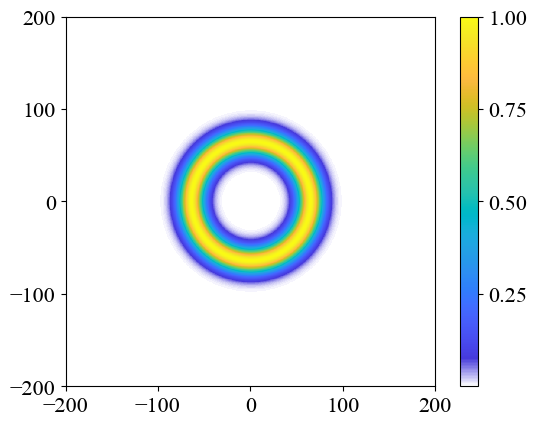

In [48]:
radial_laser_input_sum = laser.sum()
radial_laser_input_max = laser.max()
radial_laser_input_norm = laser.T / radial_laser_input_max
plt.imshow(radial_laser_input_norm, aspect='equal', origin='lower', cmap=cmap, 
           extent=[-Y_INPUT_RANGE*1e-4, Y_INPUT_RANGE*1e-4, -Y_INPUT_RANGE*1e-4, Y_INPUT_RANGE*1e-4])

FONT_SIZE = 16
ticks = np.array([-200, -100, 0, 100, 200])
plt.xticks(ticks, fontsize=FONT_SIZE)
plt.yticks(ticks, fontsize=FONT_SIZE)

cbar = plt.colorbar(ticks=[.25, .5, .75, 1])
cbar.ax.tick_params(labelsize=FONT_SIZE)

In [49]:
output_Et_y = input_field.output_Et_field_y
output_Et_z = input_field.output_Et_field_z

intensity = np.abs(output_Et_y)**2 + np.abs(output_Et_z)**2

intensity = intensity / intensity.max()

y_vals = input_field.prop.y_vals_output
times = input_field.prop.times
z_vals = input_field.prop.z_vals_output

intensity = np.swapaxes(intensity, axis1=0, axis2=1)

In [50]:
tmin = -100
tmax = 100
targ_min = np.argmin(np.abs(times - tmin))
targ_max = np.argmin(np.abs(times - tmax))

rmin = -20
rmax = 20
rarg_min = np.argmin(np.abs(y_vals - rmin))
rarg_max = np.argmin(np.abs(y_vals - rmax))

times_clipped = times[targ_min:targ_max]
y_vals_clipped = y_vals[rarg_min:rarg_max]

intensity_clipped = intensity[targ_min:targ_max, rarg_min:rarg_max, rarg_min:rarg_max]

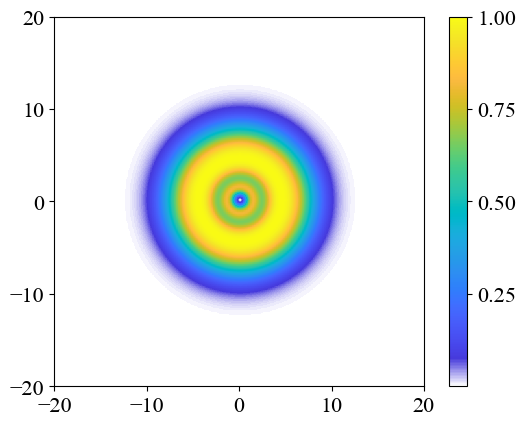

In [51]:
radial_laser_foil = np.sum(intensity_clipped[:, :, :].T, axis=2)
radial_laser_foil_sum = radial_laser_foil.sum()
radial_laser_foil_max = radial_laser_foil.max()
radial_laser_foil_norm = radial_laser_foil / radial_laser_foil_max

plt.imshow(radial_laser_foil_norm, aspect='equal', origin='lower', extent=[rmin, rmax, rmin, rmax], cmap=cmap)

FONT_SIZE = 16
ticks = np.array([-20, -10, 0, 10, 20])
plt.xticks(ticks, fontsize=FONT_SIZE)
plt.yticks(ticks, fontsize=FONT_SIZE)

cbar = plt.colorbar(ticks=[.25, .5, .75, 1])
cbar.ax.tick_params(labelsize=FONT_SIZE)

In [ ]:
prefix = "fig1_radial"
save_to_matlab(
    intensity_clipped, 
    y_vals_clipped,
    times_clipped, 
    t_center=None, x_center=None, y_center=None, windowt=None, windowx=None,
    filename=FIGURE_DATA_DIR+prefix+"_output_t_tot"
)

### 4 Beam

In [52]:
laser_4_petal = dataclasses.replace(laser_parameters_obj)

laser_4_petal.polarization = constants.RADIAL
laser_4_petal.spatial_shape = constants.PETAL_N
laser_4_petal.num_petals = 4

In [53]:
# Create the laser object
input_field_4petal = input_laser_field.InputField(propagation_parameters_obj, laser_4_petal, 
                                           advanced_parameters_obj, verbose=True)

# Populate the input grid
input_field_4petal.generate_input_Ew_field(req_low_mem = True)

print("Generating Output Ew Field")
propagator.generate_output_Ew_field(input_field_4petal)

print("Generating Output Et Field")
propagator.generate_output_Et_field_from_Ew(input_field_4petal)

#### Ranges ####
Spatial Dimensions: 2
Y Input Range: -2000000.0 2000000.0
Z Input Range: -2000000.0 2000000.0
Y Output Range: -30.0 30.0
Z Output Range: -30.0 30.0
Time Range: -400.000001 399.999999
Omega Range: -8.03855030237334 8.030699955691336
#### Resolutions ####
Dy Input: 15686.274509803858
Dz Input: 15686.274509803858
Dy Output: 0.234375
Dz Output: 0.234375
Dt: 0.39081582804101345
Dw: 0.007850146682004677
#### Other Parameters ####
Omega0: 2.354564459136067
Delta Omega: 0.07849400150103164
Entrance Waist: 200000.0
Focus: 3141592.6529614744
F#: 1.9285377599321925
Using grating eq with separation: [-1020000.0]
Generating Output Ew Field
Generating Output Et Field


In [54]:
laser_ey = np.sum(input_field_4petal.input_Ew_field_y, axis=0)
laser_ez = np.sum(input_field_4petal.input_Ew_field_z, axis=0)

laser = np.abs(laser_ey)**2 + np.abs(laser_ez)**2

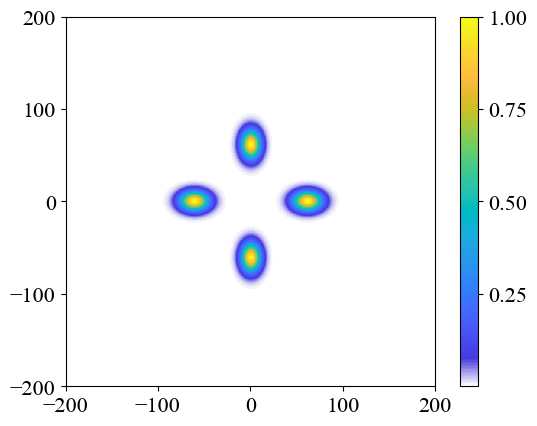

In [55]:
petal4_laser_input_norm = laser.T / np.abs(laser).max()

plt.imshow(petal4_laser_input_norm, aspect='equal', origin='lower', cmap=cmap, 
           extent=[-Y_INPUT_RANGE * 1e-4, Y_INPUT_RANGE * 1e-4, -Y_INPUT_RANGE * 1e-4, Y_INPUT_RANGE * 1e-4])

FONT_SIZE = 16
ticks = np.array([-200, -100, 0, 100, 200])
plt.xticks(ticks, fontsize=FONT_SIZE)
plt.yticks(ticks, fontsize=FONT_SIZE)

cbar = plt.colorbar(ticks=[.25, .5, .75, 1])
cbar.ax.tick_params(labelsize=FONT_SIZE)

In [56]:
output_Et_y = input_field_4petal.output_Et_field_y
output_Et_z = input_field_4petal.output_Et_field_z

intensity = np.abs(output_Et_y)**2 + np.abs(output_Et_z)**2

intensity = intensity / intensity.max()

y_vals = input_field_4petal.prop.y_vals_output
times = input_field_4petal.prop.times
z_vals = input_field_4petal.prop.z_vals_output

intensity = np.swapaxes(intensity, axis1=0, axis2=1)

In [57]:
tmin = -100
tmax = 100
targ_min = np.argmin(np.abs(times - tmin))
targ_max = np.argmin(np.abs(times - tmax))

rmin = -20
rmax = 20
rarg_min = np.argmin(np.abs(y_vals - rmin))
rarg_max = np.argmin(np.abs(y_vals - rmax))

times_clipped = times[targ_min:targ_max]
y_vals_clipped = y_vals[rarg_min:rarg_max]

intensity_clipped = intensity[targ_min:targ_max, rarg_min:rarg_max, rarg_min:rarg_max]

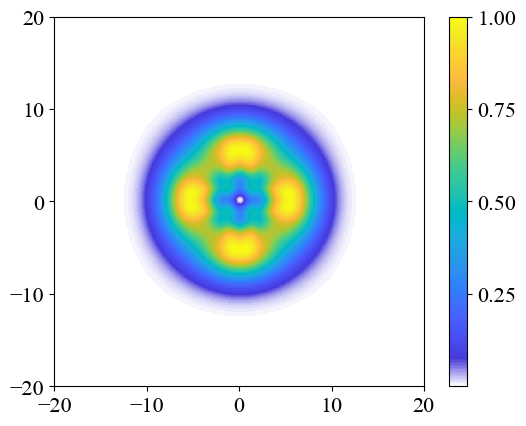

In [58]:
petal4_laser_foil = np.sum(intensity_clipped[:, :, :].T, axis=2)
petal4_laser_foil_sum = petal4_laser_foil.sum()
petal4_laser_foil_max = petal4_laser_foil.max()
petal4_laser_foil_norm = petal4_laser_foil / petal4_laser_foil_max

plt.imshow(petal4_laser_foil_norm, aspect='equal', origin='lower', extent=[rmin, rmax, rmin, rmax], cmap=cmap)

FONT_SIZE = 16
ticks = np.array([-20, -10, 0, 10, 20])
plt.xticks(ticks, fontsize=FONT_SIZE)
plt.yticks(ticks, fontsize=FONT_SIZE)

cbar = plt.colorbar(ticks=[.25, .5, .75, 1])
cbar.ax.tick_params(labelsize=FONT_SIZE)

In [ ]:
prefix = "fig1_4petal"
save_to_matlab(
    intensity_clipped, 
    y_vals_clipped,
    times_clipped, 
    t_center=None, x_center=None, y_center=None, windowt=None, windowx=None,
    filename=FIGURE_DATA_DIR+prefix+"_output_t_tot"
)

# Fig. 3

### (a-c)

In [2]:
# Propagation Parameters

SPATIAL_DIMENSIONS = 2
PROPAGATION_TYPE = constants.RAYLEIGH_SOMMERFELD
MONOCHROMATIC_ASSUMPTION = False

# INPUT PLANE
Y_INPUT_RANGE = 10 * 20e4
Z_INPUT_RANGE = Y_INPUT_RANGE
N_Y_INPUT = (2 ** 8)
N_Z_INPUT = (2 ** 8)
Y_VALS_INPUT = np.linspace(-Y_INPUT_RANGE, Y_INPUT_RANGE, N_Y_INPUT)
Z_VALS_INPUT = np.linspace(-Z_INPUT_RANGE, Z_INPUT_RANGE, N_Z_INPUT)

# OUTPUT PLANE
Y_OUTPUT_RANGE = 30
Z_OUTPUT_RANGE = Y_OUTPUT_RANGE
N_Y_OUTPUT = (2 ** 8) + 1
N_Z_OUTPUT = (2 ** 8) + 1
Y_VALS_OUTPUT = np.linspace(-Y_OUTPUT_RANGE, Y_OUTPUT_RANGE, N_Y_OUTPUT)
Z_VALS_OUTPUT = np.linspace(-Z_OUTPUT_RANGE, Z_OUTPUT_RANGE, N_Z_OUTPUT)

# TIME DIMENSION
T_RANGE = 400
N_T = (2 ** 11)

TIMES = np.linspace(-T_RANGE, T_RANGE, N_T)
TIMES -= 0.000001
DT = TIMES[1] - TIMES[0]
OMEGAS = np.fft.fftshift(np.fft.fftfreq(len(TIMES), DT / (2*np.pi)))
OMEGAS -= 0.0000001

# OTHER
SAVE_DATA_AS_FILES = False
DATA_DIRECTORY_PATH = "../trash/"
LOW_MEM = False # False is faster (haven't run benchmarks on how much faster), but requires more RAM

In [3]:
# Laser Parameters
WAVELENGTH = 0.800  # um
REF_FREQ = (2*np.pi*constants.C_SPEED) / (WAVELENGTH * 1e-6)
OMEGA0 = REF_FREQ * 1e-15  # rad / PHz

POLARIZATION = constants.RADIAL
SPATIAL_SHAPE = constants.RADIAL_CHIRP
SPATIAL_GAUSSIAN_ORDER = 1
TEMPORAL_SHAPE = constants.GAUSSIAN_T
TEMPORAL_GAUSSIAN_ORDER = 1
PHASE_OFFSET = 0  # Constant phase shift


WAIST_IN = 20e4

# Used for beams with an annulus
#DELTAX = 3.0508972995880104 * WAIST_IN
DELTAX = 3.072506017553855 * WAIST_IN

# Used for spatial chirp
USE_GRATING_EQ = True
ALPHA = 0
GRATING_SEPARATION = [-102e4]
GRATING_ANGLE_OF_INCIDENCE = [np.deg2rad(52.8)]
GROOVE_PERIOD = [1 / 1480e-3]
DIFFRACTION_ORDER = [1]

PULSE_FWHM = 30.
SPOT_SIZE = 4.
OUTPUT_DISTANCE_FROM_FOCUS = -37.25073157017444 + 8.5

NORMALIZE_TO_A0 = False
PEAK_A0 = 21.
TOTAL_ENERGY = 981660.9897641353 * (23./23.1799)

# Used for LG beams
L = 1

# Used for petal beams
NUM_PETALS = 4
WAIST_IN_RADIAL = 20e4
WAIST_IN_AZIMUTHAL = (20 / 1.438399455970175) * 1e4

propagation_parameters_obj = propagation_parameters.PropagationParameters(
    spatial_dimensions=SPATIAL_DIMENSIONS, propagation_type=PROPAGATION_TYPE, monochromatic_assumption=MONOCHROMATIC_ASSUMPTION, 
    y_input_range=Y_INPUT_RANGE, z_input_range=Z_INPUT_RANGE, N_y_input=N_Y_INPUT, N_z_input=N_Z_INPUT, 
    y_vals_input=Y_VALS_INPUT, z_vals_input=Z_VALS_INPUT, y_output_range=Y_OUTPUT_RANGE, z_output_range=Z_OUTPUT_RANGE,
    N_y_output=N_Y_OUTPUT, N_z_output=N_Z_OUTPUT, y_vals_output=Y_VALS_OUTPUT, z_vals_output=Z_VALS_OUTPUT,
    N_t=N_T, t_range=T_RANGE, times=TIMES, omegas=OMEGAS, save_data_as_files=SAVE_DATA_AS_FILES,
    data_directory_path=DATA_DIRECTORY_PATH, low_mem=LOW_MEM
)

laser_parameters_obj = laser_parameters.LaserParameters(
    wavelength=WAVELENGTH, ref_freq=REF_FREQ, omega0=OMEGA0, polarization=POLARIZATION,
    spatial_shape=SPATIAL_SHAPE, spatial_gaussian_order=SPATIAL_GAUSSIAN_ORDER, temporal_shape=TEMPORAL_SHAPE,
    temporal_gaussian_order=TEMPORAL_GAUSSIAN_ORDER, phase_offset=PHASE_OFFSET, deltax=DELTAX, pulse_fwhm=PULSE_FWHM, 
    spot_size=SPOT_SIZE, waist_in=WAIST_IN, output_distance_from_focus=OUTPUT_DISTANCE_FROM_FOCUS, 
    normalize_to_a0=NORMALIZE_TO_A0, peak_a0=PEAK_A0, total_energy=TOTAL_ENERGY, l=L, num_petals=NUM_PETALS, 
    waist_in_radial=WAIST_IN_RADIAL, waist_in_azimuthal=WAIST_IN_AZIMUTHAL
)

# Advanced Parameters
GRATING_PARAMS = advanced_parameters.GratingParameters(
    use_grating_eq=USE_GRATING_EQ,
    alpha=ALPHA,
    grating_aois=GRATING_ANGLE_OF_INCIDENCE,
    groove_periods=GROOVE_PERIOD,
    diffraction_orders=DIFFRACTION_ORDER,
    grating_separations=GRATING_SEPARATION
)


CENTER_PEAK_EFIELD_AT_0 = True
AXICON_ANGLE = 0
ECHELON_DELAY = 0
advanced_parameters_obj = advanced_parameters.AdvancedParameters(
    center_peak_E_at_0=CENTER_PEAK_EFIELD_AT_0,
    grating_params=GRATING_PARAMS,
    axicon_angle=AXICON_ANGLE, echelon_delay=ECHELON_DELAY
)

In [4]:
# Create the laser object
input_field = input_laser_field.InputField(propagation_parameters_obj, laser_parameters_obj, 
                                           advanced_parameters_obj, verbose=True)

# Populate the input grid
input_field.generate_input_Ew_field(req_low_mem = True)

#### Ranges ####
Spatial Dimensions: 2
Y Input Range: -2000000.0 2000000.0
Z Input Range: -2000000.0 2000000.0
Y Output Range: -30.0 30.0
Z Output Range: -30.0 30.0
Time Range: -400.000001 399.999999
Omega Range: -8.03855030237334 8.030699955691336
#### Resolutions ####
Dy Input: 15686.274509803858
Dz Input: 15686.274509803858
Dy Output: 0.234375
Dz Output: 0.234375
Dt: 0.39081582804101345
Dw: 0.007850146682004677
#### Other Parameters ####
Omega0: 2.354564459136067
Delta Omega: 0.07849400150103164
Entrance Waist: 200000.0
Focus: 3141592.6529614744
F#: 1.9285377599321925
Using grating eq with separation: [-1020000.0]


/Users/kylecharbonnet/Code/UCI/barty-personal/new_jet/jet_paper_data_submission/./Arbitrary-Laser-Fields-for-PIC/fourier_prop/laser_input/field_shape_functions.py:258: RuntimeWarning: invalid value encountered in arcsin
  separation*np.tan(np.arcsin(m*2*np.pi*constants.C_UM_FS/(omega*groove_period)-np.sin(aoi))),


(1.5, 2.5)

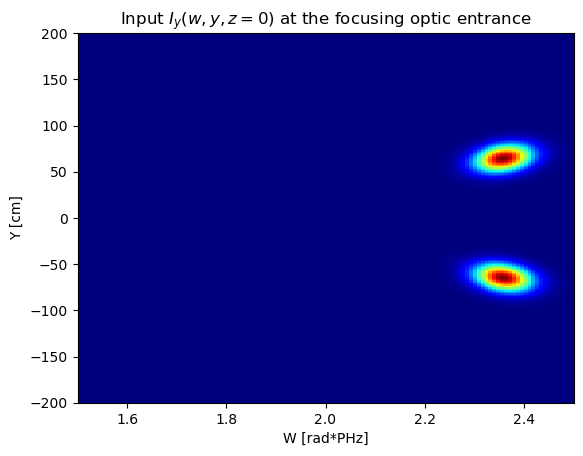

In [5]:
plt.figure()

wbound = input_field.prop.omegas.max()
ew_input = laser_visualization.get_Ew_YW(input_field, z_val=0, is_Ey=True, ybound=0, wbound=wbound, is_output=False)

start_index = np.argmin(np.abs(input_field.prop.omegas - 0))
end_index = np.argmin(np.abs(input_field.prop.omegas - wbound))

ew_input_imshow = np.flip(ew_input[start_index:end_index, :].T, axis=0)

Iw_input_imshow = np.abs(ew_input_imshow) ** 2
Iw_input_imshow = Iw_input_imshow / Iw_input_imshow.max()

plt.imshow(Iw_input_imshow, aspect='auto', extent=[0, wbound, -Y_INPUT_RANGE * 1e-4, Y_INPUT_RANGE * 1e-4], cmap='jet', interpolation="None")
plt.xlabel('W [rad*PHz]')
plt.ylabel('Y [cm]')
plt.title("Input $I_{y}(w, y, z=0)$ at the focusing optic entrance")
plt.xlim(1.5, 2.5)

In [6]:
print("Generating Output Ew Field")
propagator.generate_output_Ew_field(input_field)

print("Generating Output Et Field")
propagator.generate_output_Et_field_from_Ew(input_field)

Generating Output Ew Field
Generating Output Et Field


(-200.0, 200.0)

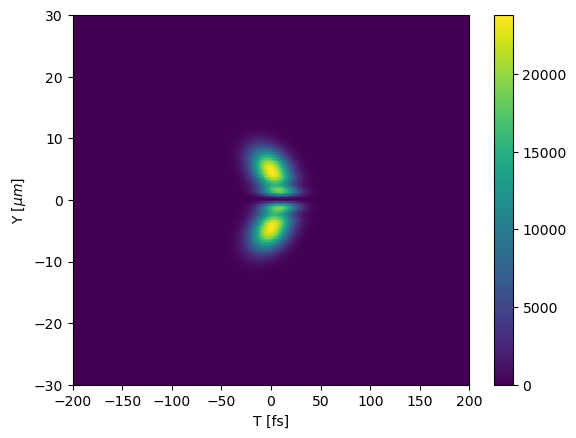

In [7]:
plt.figure()

ybound = Y_OUTPUT_RANGE
tbound = input_field.prop.times.max()
et_output = laser_visualization.get_Et_YT(input_field, z_val=0, is_Ey=True, ybound=ybound, tbound=tbound, is_output=True)

et_output_imshow = np.flip(et_output[:, :].T, axis=1)
It_y = np.abs(et_output_imshow)**2
et_output_imshow = et_output_imshow / np.abs(et_output_imshow.real).max()


plt.imshow(It_y.real, origin='lower', aspect='auto', extent=[-tbound, tbound, -ybound, ybound], cmap='viridis', interpolation="None")

plt.colorbar()
plt.xlabel('T [fs]')
plt.ylabel('Y [$\\mu m$]')
plt.xlim(-200, 200)

(0.0, 200.0)

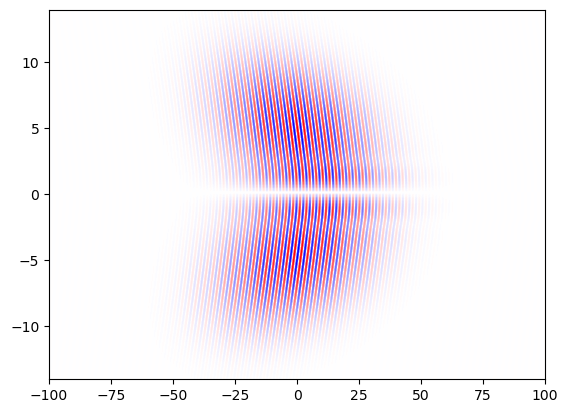

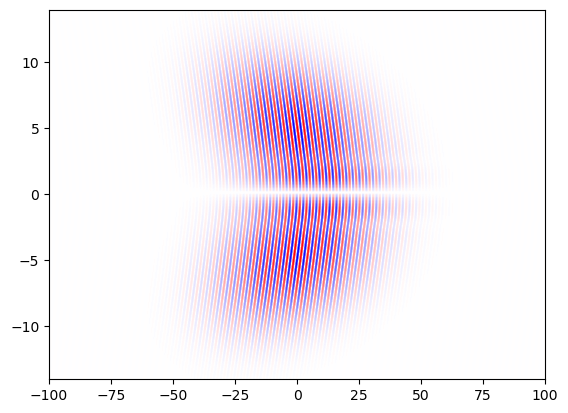

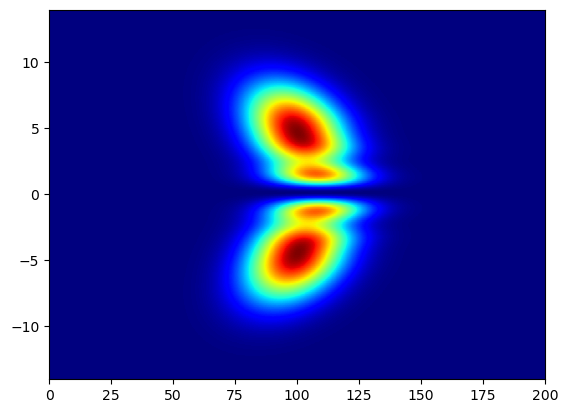

In [8]:
plt.imshow(et_output_imshow.real, aspect='auto', origin='lower', cmap='bwr', extent=[-tbound, tbound, -ybound, ybound])
plt.xlim(-100, 100)
plt.ylim(-14, 14)

plt.figure()
t_window = 100
t_lo_i = np.argmin(np.abs(input_field.prop.times + t_window))
t_hi_i = np.argmin(np.abs(input_field.prop.times - t_window))

et_clipped = et_output_imshow[:, t_lo_i:t_hi_i]
plt.imshow(et_clipped.real, aspect='auto', origin='lower', cmap='bwr', extent=[-t_window, t_window, -ybound, ybound])
plt.ylim(-14, 14)


E_r = et_clipped.T
LASER_START = 100e-15
t_vals = np.linspace(-100e-15, 100e-15, E_r.shape[0]) + LASER_START
y_vals = np.linspace(-30e-6, 30e-6, E_r.shape[1])

E0_peak = 4.88e13 # V/m for a0 = 17
E_r = (E_r / np.abs(E_r).max()) * E0_peak


N_t = 1600
T_MAX = 800e-15
new_t = np.linspace(0, T_MAX, N_t)
new_r = np.linspace(-14e-6, 14e-6, 200)

T_new, R_new = np.meshgrid(new_t, new_r, indexing='ij')

points_in = (t_vals, y_vals)
points_out = (new_t, new_r)
interp_func = scipy.interpolate.RegularGridInterpolator(points_in, np.abs(E_r)**2, bounds_error=False, fill_value=0, method='cubic')

E_r_interp_squared = interp_func((T_new, R_new))

# No 1/2 factor since the light is circularly polarized
I_r_interp = scipy.constants.epsilon_0 * scipy.constants.c * E_r_interp_squared

plt.figure()
plt.imshow(I_r_interp.real.T, aspect='auto', origin='lower', cmap='jet', extent=[new_t[0] * 1e15, new_t[-1] * 1e15, new_r[0] * 1e6, new_r[-1] * 1e6])

plt.xlim(0, 200)

In [9]:
from scipy.constants import m_p, e, c, epsilon_0, m_e

# === PARAMETERS ===
#dx = 28e-6 / 200  # 200 points over 28 microns
dt = new_t[1] - new_t[0]        
r_range = new_r  
t_range = new_t     
x0 = 0.0                                   
foil_thickness = 600e-9

n_cr = 30
n_cr_si = n_cr * (epsilon_0 * m_e * (OMEGA0 * 1e15)**2) / (e**2)


omega = 2 * np.pi * c / 1e-6  # for 1 micron laser

def pressure_term(I):
    return ((2 * I) / c) * (1 / (m_p * c))


def normal_vector_x(rprime, xprime):
    denom = np.sqrt(rprime**2 + xprime**2)
    return np.where(denom == 0, 0, (1 / denom) * rprime)


def normal_vector_r(rprime, xprime):
    denom = np.sqrt(rprime**2 + xprime**2)
    return np.where(denom == 0, 0, (1 / denom) * -xprime)
    
def cos_phi(nx, nr, vx, vr):
    v_mag = np.sqrt(vx**2 + vr**2)

    return np.where(v_mag == 0, 0, (nx * vx + nr * vr) / v_mag)

def beta(vx, vr):
    v_mag = np.sqrt(vx**2 + vr**2)
    return v_mag / c

def kappa(cosphi, cosalpha, beta_val):
    return (cosalpha - beta_val*cosphi) / cosalpha

def last_term(cosphi, cosalpha, beta_val):
    return (beta_val*cosphi - cosalpha) / (1 - (beta_val*cosphi)**2)
    
def dsdn(r, r0, density):
    return np.abs(r/r0) / (density * foil_thickness)
    
    

n_particles = 120
r0_indices = np.linspace(0, len(r_range) - 1, n_particles, dtype=int)
r0_vals = r_range[r0_indices]
dr = r0_vals[1] - r0_vals[0]

# Initialize arrays
x = np.zeros((len(t_range), n_particles))
r = np.zeros((len(t_range), n_particles))
vx = np.zeros((len(t_range), n_particles))
vr = np.zeros((len(t_range), n_particles))
px = np.zeros((len(t_range), n_particles))
pr = np.zeros((len(t_range), n_particles))
drdr0 = np.zeros((len(t_range), n_particles))
dxdr0 = np.zeros((len(t_range), n_particles))

r[0] = r0_vals

pressure_vals = pressure_term(I_r_interp)

In [10]:
for ti in range(1, len(t_range)):

    for i, ri in enumerate(r0_indices):
        if i == 0:
            drdr0[ti, i] = (r[ti-1, i+1] - r[ti-1, i]) / dr
        elif i == len(r0_indices) - 1:
            drdr0[ti, i] = (r[ti-1, i] - r[ti-1, i-1]) / dr
        else:
            drdr0[ti, i] = (r[ti-1, i+1] - r[ti-1, i-1]) / (2 * dr)
        
        if i == 0:
            dxdr0[ti, i] = (x[ti-1, i+1] - x[ti-1, i]) / dr
        elif i == len(r0_indices) - 1:
            dxdr0[ti, i] = (x[ti-1, i] - x[ti-1, i-1]) / dr
        else:
            dxdr0[ti, i] = (x[ti-1, i+1] - x[ti-1, i-1]) / (2 * dr)
        
        
        nx = normal_vector_x(drdr0[ti, i], dxdr0[ti, i])
        nr = normal_vector_r(drdr0[ti, i], dxdr0[ti, i])
        
        cosalpha = nx
        cosphi = cos_phi(nx, nr, vx[ti - 1, i], vr[ti - 1, i])
        beta_val = beta(vx[ti - 1, i], vr[ti - 1, i])
        kappa_val = kappa(cosphi, cosalpha, beta_val)
        last = last_term(cosphi, cosalpha, beta_val)

        
        pos_index = np.argmin(np.abs(new_r - r[ti-1, i]))
        

        pressure_curr = pressure_vals[ti, pos_index]
        
        dsdn_term = dsdn(r[ti - 1, i], r[0, i], n_cr_si)
        
        final_coeff = -kappa_val * (pressure_curr * cosalpha) * last * dsdn_term


        a_r = final_coeff * nr
        pr[ti, i] = pr[ti - 1, i] + a_r * dt
        
        a_x = final_coeff * nx
        px[ti, i] = px[ti - 1, i] + a_x * dt
        
        p_mag_sq = pr[ti, i]**2 + px[ti, i]**2
        gamma = np.sqrt(1 + p_mag_sq)


        vr[ti, i] = pr[ti, i] * c / gamma
        vx[ti, i] = px[ti, i] * c / gamma

        r[ti, i] = r[ti-1, i] + vr[ti-1, i] * dt
        x[ti, i] = x[ti-1, i] + vx[ti-1, i] * dt




/var/folders/wn/_6l261dd6ssfsqpqmfrs1n0w0000gn/T/ipykernel_82797/1014826846.py:33: RuntimeWarning: invalid value encountered in scalar divide
  return np.where(v_mag == 0, 0, (nx * vx + nr * vr) / v_mag)


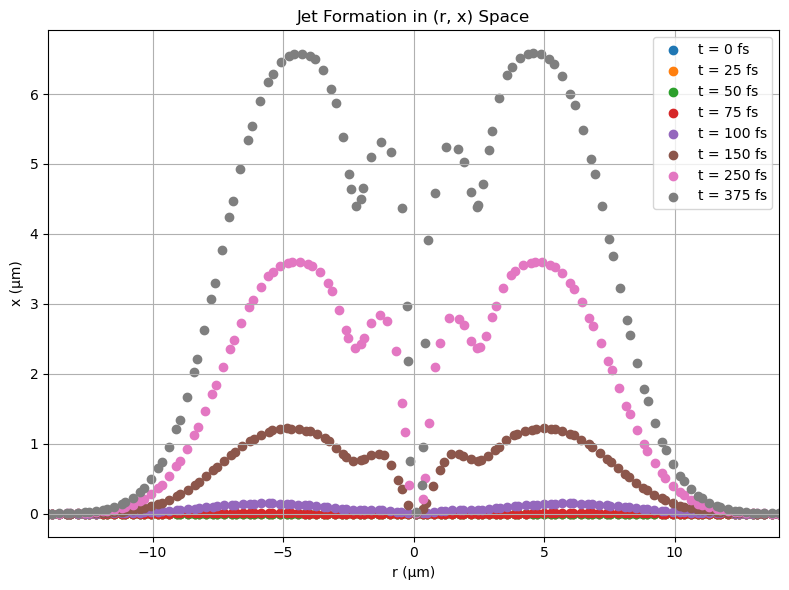

In [11]:
plt.figure(figsize=(8, 6))
for ti in [0, 50, 100, 150, 200, 300, 500, 750]:
    plt.scatter(r[ti]*1e6, x[ti]*1e6, label=f"t = {t_range[ti]*1e15:.0f} fs")
plt.xlabel("r (µm)")
plt.ylabel("x (µm)")
plt.title("Jet Formation in (r, x) Space")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(-14, 14)
#plt.ylim(0, 30)
plt.show()

In [12]:
S_radial_high_res = happi.Open(PATH_SIMS + RADIAL_SIM, verbose=False)

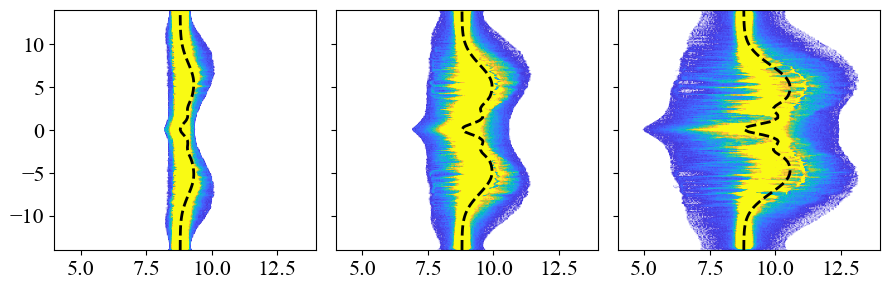

In [13]:
ts_probe_1 = 3400
ts_model_1 = 120
ions = S_radial_high_res.Probe(0, "Rho_hydrogen_ions", units=['um', 'fs'], cmap='jet', timesteps = ts_probe_1)
ions_data_1 = np.array(ions.getData()[0])

ts_probe_2 = 4000
ts_model_2 = 147
ions = S_radial_high_res.Probe(0, "Rho_hydrogen_ions", units=['um', 'fs'], cmap='jet', timesteps = ts_probe_2)
ions_data_2 = np.array(ions.getData()[0])

ts_probe_3 = 4600
ts_model_3 = 173
ions = S_radial_high_res.Probe(0, "Rho_hydrogen_ions", units=['um', 'fs'], cmap='jet', timesteps = ts_probe_3)
ions_data_3 = np.array(ions.getData()[0])


FONT_SIZE = 16
xticks = np.array([5, 7.5, 10, 12.5])
yticks = np.array([-10, -5, 0, 5, 10])
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

ax[0].imshow(ions_data_1.T, aspect='auto', origin='lower', extent=[0, 48, -14, 14], vmin=.0001, vmax=5, cmap=cmap)
ax[0].plot(x[ts_model_1 * 2]*1e6 + 8.8, r[ts_model_1 * 2]*1e6, color='black', linewidth=2, linestyle='--')
ax[0].set_xlim(4, 14)

ax[0].set_xticks(xticks)
ax[0].set_yticks(yticks)
ax[0].tick_params(axis='both', which='major', labelsize=FONT_SIZE)

ax[1].imshow(ions_data_2.T, aspect='auto', origin='lower', extent=[0, 48, -14, 14], vmin=.0001, vmax=5, cmap=cmap)
ax[1].plot(x[ts_model_2 * 2]*1e6 + 8.8, r[ts_model_2 * 2]*1e6, color='black', linewidth=2, linestyle='--')
ax[1].set_xlim(4, 14)
ax[1].set_xticks(xticks)
ax[1].set_yticks(yticks)
ax[1].tick_params(axis='both', which='major', labelleft=False, labelsize=FONT_SIZE)

last = ax[2].imshow(ions_data_3.T, aspect='auto', origin='lower', extent=[0, 48, -14, 14], vmin=.0001, vmax=5, cmap=cmap)
ax[2].plot(x[ts_model_3 * 2]*1e6 + 8.8, r[ts_model_3 * 2]*1e6, color='black', linewidth=2, linestyle='--')
ax[2].set_xlim(4, 14)
ax[2].set_xticks(xticks)
ax[2].set_yticks(yticks)
ax[2].tick_params(axis='both', which='major', labelleft=False, labelsize=FONT_SIZE)


fig.tight_layout()

### (d-e)

In [16]:
S_radial_high_res = happi.Open(PATH_SIMS + RADIAL_SIM, verbose=False)

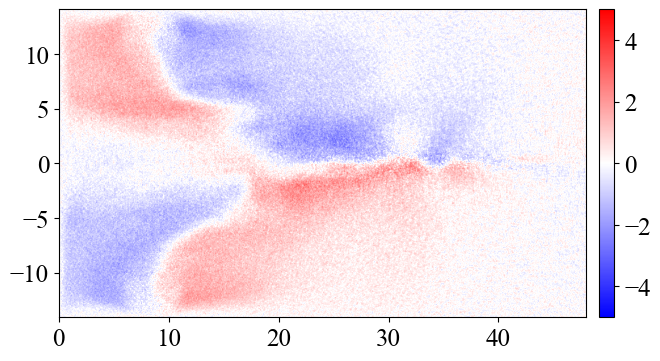

In [17]:
ts = 15000
bz = S_radial_high_res.Probe(0, "Bz", units=['um', 'fs', 'kT'], timesteps = ts, vmin=-2, vmax=2, cmap='bwr')

bz_data = np.array(bz.getData()[0])

plt.figure(figsize=(8.2, 4))
plt.imshow(bz_data.T, origin='lower', aspect='auto', extent=[0, 48, -14.08, 14.08], vmin=-5, vmax=5, cmap='bwr')

FONT_SIZE = 18
plt.tick_params(axis='both', which='major', labelsize=FONT_SIZE)

cbar = plt.colorbar(pad=0.02)
cbar.ax.tick_params(labelsize=FONT_SIZE)

(8.5, 20.0)

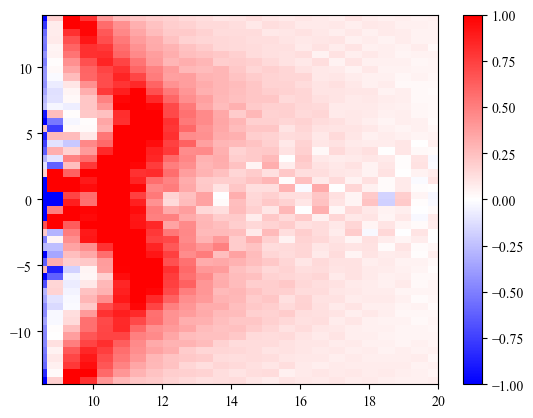

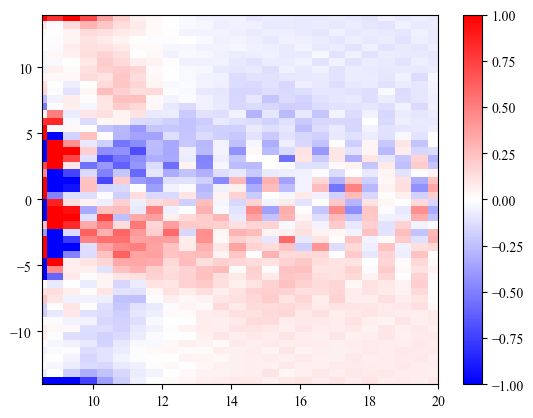

In [18]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

# Radial Sheath
ts = 4000
ex = S_radial_high_res.Probe(0, "Ex", units=['um', 'fs'], timesteps = ts, vmin=-1, vmax=1)
ey = S_radial_high_res.Probe(0, "Ey", units=['um', 'fs'], timesteps = ts, vmin=-1, vmax=1)

ex_data = np.array(ex.getData()[0])
ey_data = np.array(ey.getData()[0])

NEW_X_SIZE = 100
NEW_Y_SIZE = 50
ex_reshaped = rebin(ex_data, (NEW_X_SIZE, NEW_Y_SIZE))
ey_reshaped = rebin(ey_data, (NEW_X_SIZE, NEW_Y_SIZE))

plt.figure()
plt.imshow(ex_reshaped.T, origin='lower', aspect='auto', vmin=-1, vmax=1, cmap='bwr', extent=[0, 48, -14, 14])
plt.colorbar()
plt.xlim(8.5, 20)

plt.figure()
plt.imshow(ey_reshaped.T, origin='lower', aspect='auto', vmin=-1, vmax=1, cmap='bwr', extent=[0, 48, -14, 14])
plt.colorbar()
plt.xlim(8.5, 20)


(8.5, 20.0)

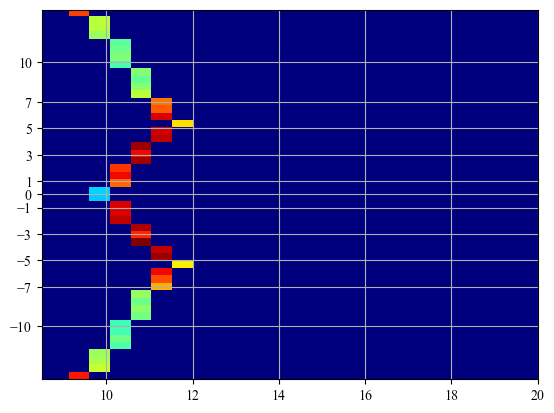

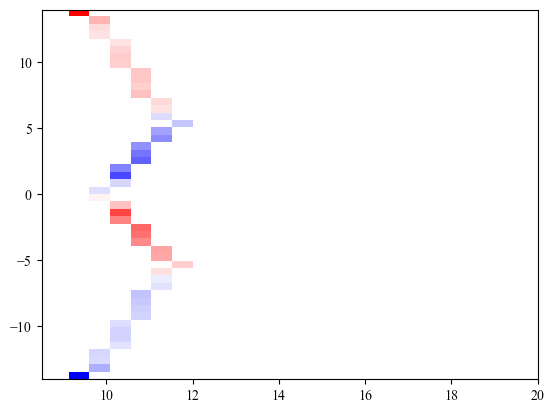

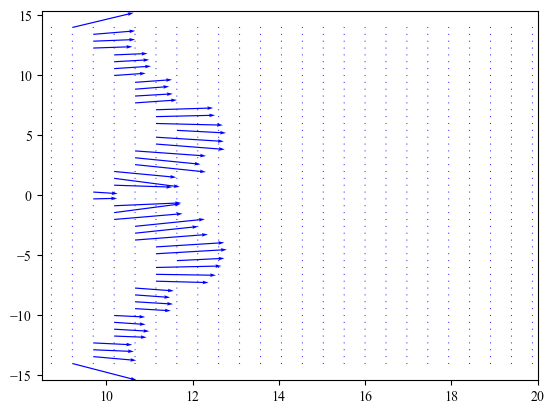

In [19]:
x_vals = np.linspace(0, 48, NEW_X_SIZE)
y_vals = np.linspace(-14, 14, NEW_Y_SIZE)
X, Y = np.meshgrid(x_vals, y_vals, indexing='ij')

start_x = np.argmin(np.abs(x_vals - 9))
sheath_points_x = (start_x, start_x+1, start_x+1, start_x+1, start_x+2, start_x+2, start_x+2, 
                   start_x+2, start_x+3, start_x+3, start_x+3, start_x+3, start_x+4, 
                   start_x+4, start_x+4, start_x+5, start_x+4, start_x+4, start_x+3, start_x+3, 
                   start_x+3, start_x+2, start_x+2, start_x+2, start_x+1, start_x+1, start_x+2, start_x+2,
                   start_x+2, start_x+3, start_x+3, start_x+3, start_x+4, start_x+4, start_x+5, start_x+4,
                   start_x+4, start_x+4, start_x+3, start_x+3, start_x+3, start_x+3, start_x+2, start_x+2,
                   start_x+2, start_x+2, start_x+1, start_x+1, start_x+1, start_x
                  )
sheath_points_y = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 
                   34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49)
ex_sheath = ex_reshaped.copy()
ey_sheath = ey_reshaped.copy()
mask = np.zeros(ex_sheath.shape, dtype=bool)
mask[sheath_points_x, sheath_points_y] = True

ex_sheath[~mask] = 0
ey_sheath[~mask] = 0
plt.figure()
plt.imshow(ex_sheath.T, aspect='auto', origin='lower', cmap='jet', extent=[0, 48, -14, 14])
plt.xlim(8.5, 20)
plt.grid()
plt.yticks([-10, -7, -5, -3, -1, 0, 1, 3, 5, 7, 10])

plt.figure()
plt.imshow(ey_sheath.T, aspect='auto', origin='lower', cmap='bwr', extent=[0, 48, -14, 14], vmin=-1, vmax=1)
plt.xlim(8.5, 20)

plt.figure()
plt.quiver(X, Y, ex_sheath, ey_sheath, scale_units='xy', angles='xy', scale=1, color='blue')
plt.xlim(8.5, 20)

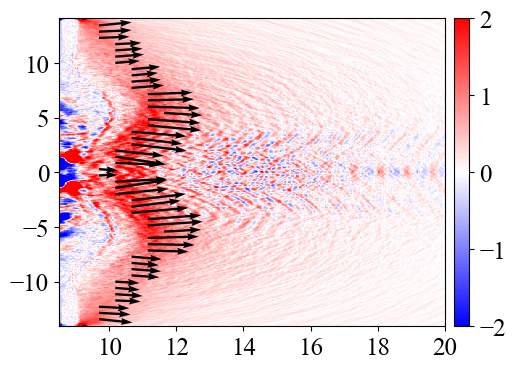

In [20]:
FONT_SIZE = 18
plt.figure(figsize=(6, 4))
plt.imshow(ex_data.T, origin='lower', aspect='auto', extent=[0, 48, -14.08, 14.08], cmap='bwr', vmin=-2, vmax=2)
cbar = plt.colorbar(pad=0.02)
cbar.ax.tick_params(labelsize=FONT_SIZE)
plt.quiver(X[mask], Y[mask], ex_sheath[mask], ey_sheath[mask], scale_units='xy', angles='xy', scale=1, color='black', width=.006)
plt.xlim(8.5, 20)

xticks = [10, 12, 14, 16, 18, 20]
yticks = [-10, -5, 0, 5, 10]
plt.xticks(xticks)
plt.yticks(yticks)
plt.tick_params(axis='both', which='major', labelsize=FONT_SIZE)

# Fig. 4

In [21]:
S_4petal = happi.Open(PATH_SIMS + BEAM4_SIM, verbose=False)
S_radial = happi.Open(PATH_SIMS + RADIAL_SIM, verbose=False)
S_g_ap_match = happi.Open(PATH_SIMS + GAUSSIAN_SIM, verbose=False)

In [22]:
ts_start = 10000
ts_middle = 15000
ts_end = 20000

petal4_start = np.array(S_4petal.Probe(0, "Rho_hydrogen_ions", cmap='jet', units=['um', 'fs'], timesteps = ts_start).getData()[0])
radial_start = np.array(S_radial.Probe(0, "Rho_hydrogen_ions", cmap='jet', units=['um', 'fs'], timesteps = ts_start).getData()[0])
gaussian_start = np.array(S_g_ap_match.Probe(0, "Rho_hydrogen_ions", cmap='jet', units=['um', 'fs'], timesteps = ts_start).getData()[0])


petal4_middle = np.array(S_4petal.Probe(0, "Rho_hydrogen_ions", cmap='jet', units=['um', 'fs'], timesteps = ts_middle).getData()[0])
radial_middle = np.array(S_radial.Probe(0, "Rho_hydrogen_ions", cmap='jet', units=['um', 'fs'], timesteps = ts_middle).getData()[0])
gaussian_middle = np.array(S_g_ap_match.Probe(0, "Rho_hydrogen_ions", cmap='jet', units=['um', 'fs'], timesteps = ts_middle).getData()[0])


petal4_end = np.array(S_4petal.Probe(0, "Rho_hydrogen_ions", cmap='jet', units=['um', 'fs'], timesteps = ts_end).getData()[0])
radial_end = np.array(S_radial.Probe(0, "Rho_hydrogen_ions", cmap='jet', units=['um', 'fs'], timesteps = ts_end).getData()[0])
gaussian_end = np.array(S_g_ap_match.Probe(0, "Rho_hydrogen_ions", cmap='jet', units=['um', 'fs'], timesteps = ts_end).getData()[0])

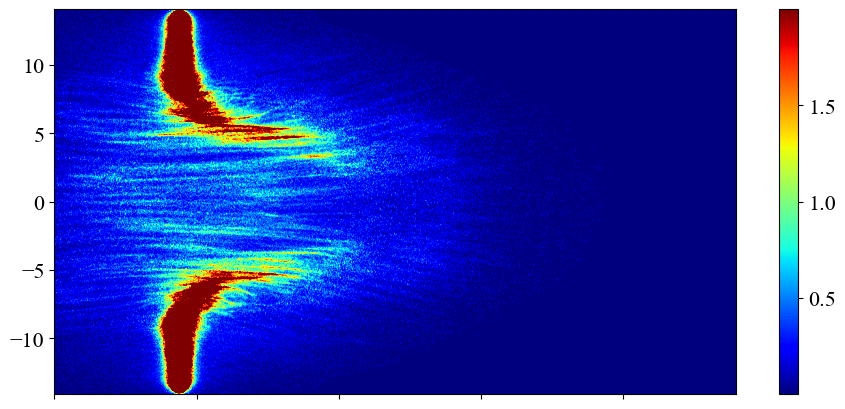

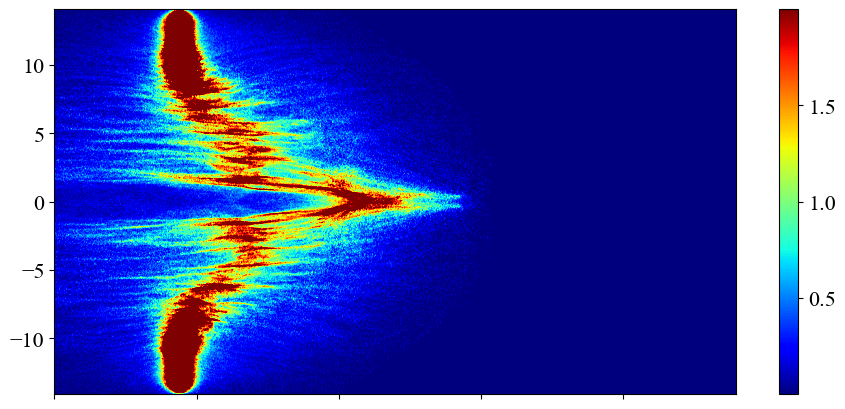

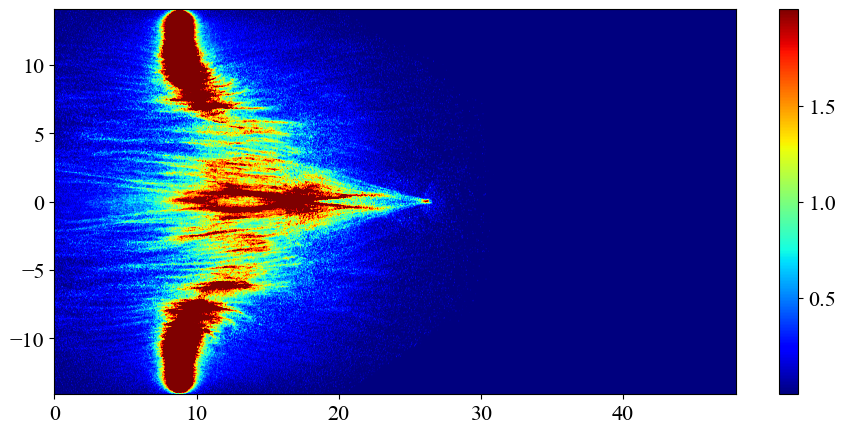

In [23]:
FONT_SIZE = 16
plt.figure(figsize=(11, 5))
plt.imshow(gaussian_start.T, origin='lower', aspect='auto', 
           extent=[0, 48, -14.08, 14.08], vmin=0, vmax=2, cmap='jet')

xticks = np.array([0, 10, 20, 30, 40])
yticks = np.array([-10, -5, 0, 5, 10])
plt.xticks(xticks, fontsize=FONT_SIZE)
plt.yticks(yticks, fontsize=FONT_SIZE)
  
plt.tick_params(axis='both', labelbottom=False)
cbar = plt.colorbar(ticks=[.5, 1, 1.5])
cbar.ax.tick_params(labelsize=FONT_SIZE)

plt.figure(figsize=(11, 5))
plt.imshow(radial_start.T, origin='lower', aspect='auto', 
           extent=[0, 48, -14.08, 14.08], vmin=0, vmax=2, cmap='jet')

xticks = np.array([0, 10, 20, 30, 40])
yticks = np.array([-10, -5, 0, 5, 10])
#plt.xticks(xticks, fontsize=FONT_SIZE)
plt.yticks(yticks, fontsize=FONT_SIZE)

plt.tick_params(axis='both', labelbottom=False)
cbar = plt.colorbar(ticks=[.5, 1, 1.5])
cbar.ax.tick_params(labelsize=FONT_SIZE)



plt.figure(figsize=(11, 5))
plt.imshow(petal4_start.T, origin='lower', aspect='auto', 
           extent=[0, 48, -14.08, 14.08], vmin=0, vmax=2, cmap='jet')

xticks = np.array([0, 10, 20, 30, 40])
yticks = np.array([-10, -5, 0, 5, 10])
plt.xticks(xticks, fontsize=FONT_SIZE)
plt.yticks(yticks, fontsize=FONT_SIZE)

plt.tick_params(axis='both', labelbottom=True)
cbar = plt.colorbar(ticks=[.5, 1, 1.5])
cbar.ax.tick_params(labelsize=FONT_SIZE)
    

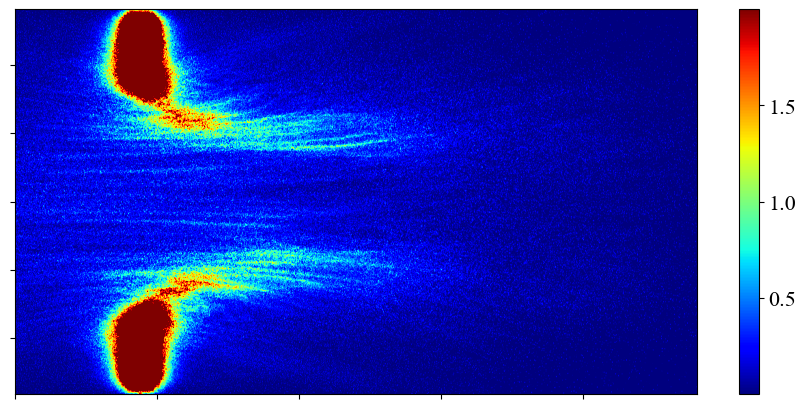

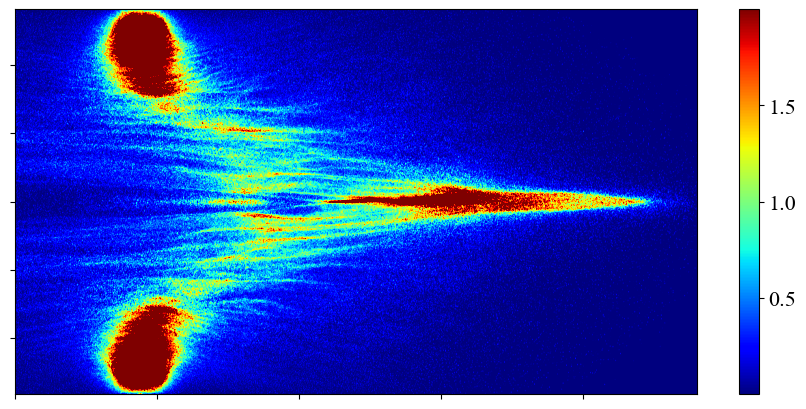

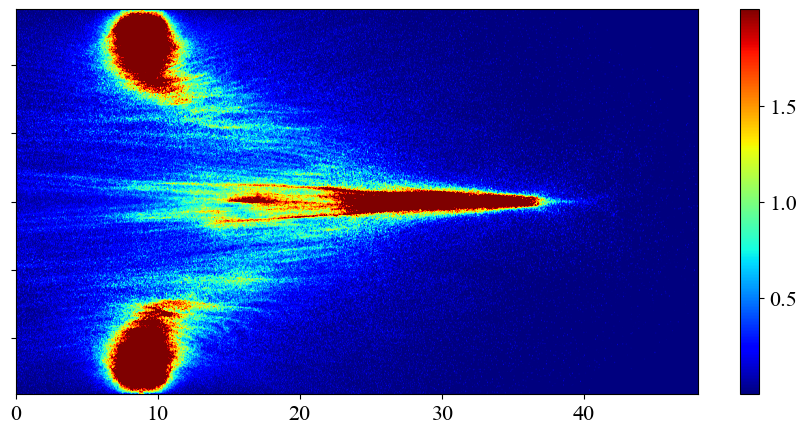

In [24]:
plt.figure(figsize=(11, 5))
plt.imshow(gaussian_middle.T, origin='lower', aspect='auto', 
           extent=[0, 48, -14.08, 14.08], vmin=0, vmax=2, cmap='jet')

xticks = np.array([0, 10, 20, 30, 40])
yticks = np.array([-10, -5, 0, 5, 10])
plt.xticks(xticks, fontsize=FONT_SIZE)
plt.yticks(yticks, fontsize=FONT_SIZE)

plt.tick_params(axis='both', labelbottom=False, labelleft=False)
cbar = plt.colorbar(ticks=[.5, 1, 1.5])
cbar.ax.tick_params(labelsize=FONT_SIZE)


plt.figure(figsize=(11, 5))
plt.imshow(radial_middle.T, origin='lower', aspect='auto', 
           extent=[0, 48, -14.08, 14.08], vmin=0, vmax=2, cmap='jet')

xticks = np.array([0, 10, 20, 30, 40])
yticks = np.array([-10, -5, 0, 5, 10])
#plt.xticks(xticks, fontsize=FONT_SIZE)
plt.yticks(yticks, fontsize=FONT_SIZE)

plt.tick_params(axis='both', labelbottom=False, labelleft=False)
cbar = plt.colorbar(ticks=[.5, 1, 1.5])
cbar.ax.tick_params(labelsize=FONT_SIZE)


plt.figure(figsize=(11, 5))
plt.imshow(petal4_middle.T, origin='lower', aspect='auto', 
           extent=[0, 48, -14.08, 14.08], vmin=0, vmax=2, cmap='jet')

xticks = np.array([0, 10, 20, 30, 40])
yticks = np.array([-10, -5, 0, 5, 10])
plt.xticks(xticks, fontsize=FONT_SIZE)
plt.yticks(yticks, fontsize=FONT_SIZE)

plt.tick_params(axis='both', labelbottom=True, labelleft=False)
cbar = plt.colorbar(ticks=[.5, 1, 1.5])
cbar.ax.tick_params(labelsize=FONT_SIZE)
    

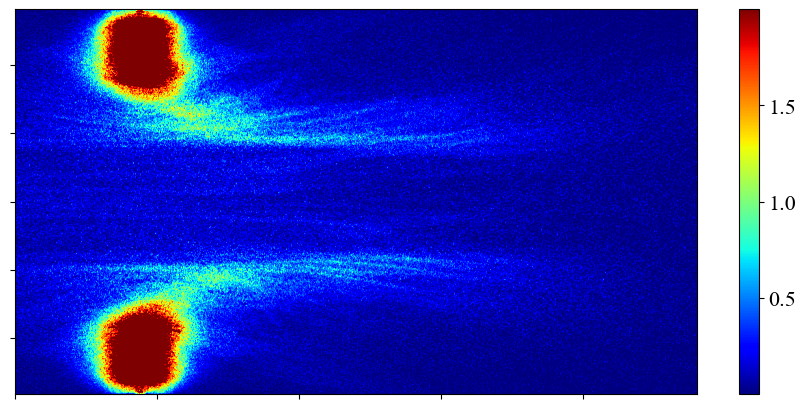

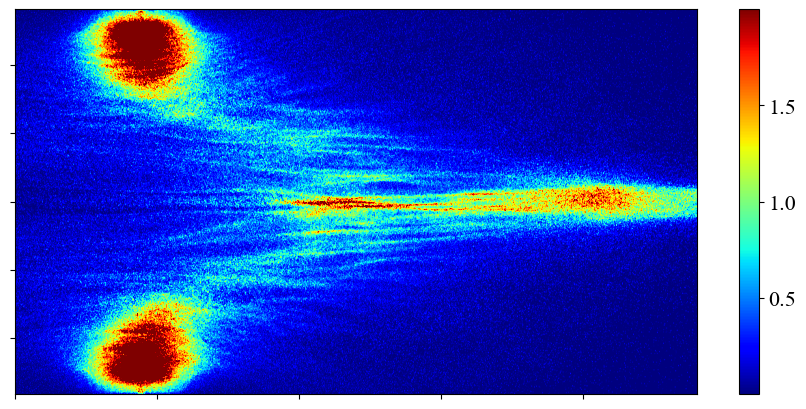

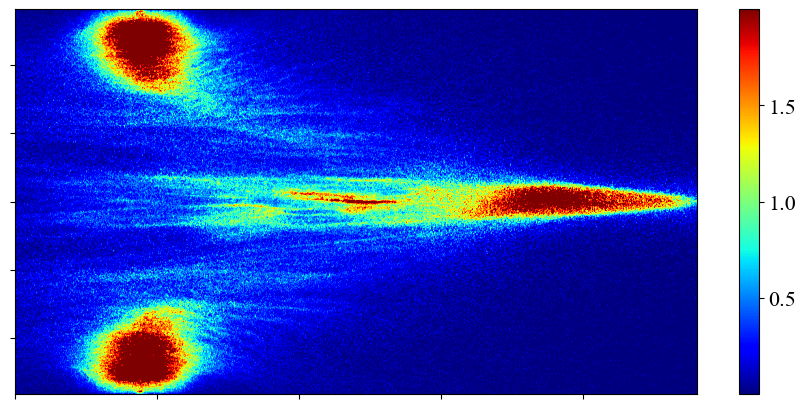

In [25]:


plt.figure(figsize=(11, 5))
plt.imshow(gaussian_end.T, origin='lower', aspect='auto', 
           extent=[0, 48, -14.08, 14.08], vmin=0, vmax=2, cmap='jet')

xticks = np.array([0, 10, 20, 30, 40])
yticks = np.array([-10, -5, 0, 5, 10])
plt.xticks(xticks, fontsize=FONT_SIZE)
plt.yticks(yticks, fontsize=FONT_SIZE)

plt.tick_params(axis='both', labelbottom=False, labelleft=False)
cbar = plt.colorbar(ticks=[.5, 1, 1.5])
cbar.ax.tick_params(labelsize=FONT_SIZE)


plt.figure(figsize=(11, 5))
plt.imshow(radial_end.T, origin='lower', aspect='auto', 
           extent=[0, 48, -14.08, 14.08], vmin=0, vmax=2, cmap='jet')

xticks = np.array([0, 10, 20, 30, 40])
yticks = np.array([-10, -5, 0, 5, 10])
#plt.xticks(xticks, fontsize=FONT_SIZE)
plt.yticks(yticks, fontsize=FONT_SIZE)

plt.tick_params(axis='both', labelbottom=False, labelleft=False)
cbar = plt.colorbar(ticks=[.5, 1, 1.5])
cbar.ax.tick_params(labelsize=FONT_SIZE)


plt.figure(figsize=(11, 5))
plt.imshow(petal4_end.T, origin='lower', aspect='auto', 
           extent=[0, 48, -14.08, 14.08], vmin=0, vmax=2, cmap='jet')

xticks = np.array([0, 10, 20, 30, 40])
yticks = np.array([-10, -5, 0, 5, 10])
plt.xticks(xticks, fontsize=FONT_SIZE)
plt.yticks(yticks, fontsize=FONT_SIZE)

plt.tick_params(axis='both', labelbottom=False, labelleft=False)
cbar = plt.colorbar(ticks=[.5, 1, 1.5])
cbar.ax.tick_params(labelsize=FONT_SIZE)
    

# Fig. 5

In [26]:
S_4petal = happi.Open(PATH_SIMS + BEAM4_SIM, verbose=False)
S_radial = happi.Open(PATH_SIMS + RADIAL_SIM, verbose=False)
S_g_ap_match = happi.Open(PATH_SIMS + GAUSSIAN_SIM, verbose=False)

In [27]:
def get_emittance_for_time(S, pbin_num):
    diag = S.ParticleBinning(pbin_num, units=["um", "fs", "1/cm^3"])
    timesteps = diag.getTimesteps()
    data = np.array(S.ParticleBinning(pbin_num, units=["um", "fs", "1/cm^3"]).getData())
    
    emittance_vals = np.zeros((data.shape[0]))
    lowest_emittance = 999999
    lowest_emittance_index = 0
    
    for t in range(emittance_vals.size):
        normalize_div_y_data = data[t] / np.sum(data[t])

        y_axis = np.linspace(0, 28.16, normalize_div_y_data.shape[0])
        div_y_axis = np.linspace(-np.pi, np.pi, normalize_div_y_data.shape[1])

        div_y_vals = np.sum(normalize_div_y_data, axis=0)
        y_vals = np.sum(normalize_div_y_data, axis=1)

        expected_y_div_y = np.sum((normalize_div_y_data * div_y_vals) * y_vals[:, np.newaxis])

        expected_y = np.sum(y_vals * y_axis)
        expected_div_y = np.sum(div_y_vals * div_y_axis)

        expected_y_squared = np.sum(y_vals * (y_axis - 14)**2)
        expected_div_y_squared = np.sum(div_y_vals * div_y_axis**2)

        emittance_vals[t] = np.sqrt(expected_div_y_squared*expected_y_squared - (expected_y_div_y**2))
        
        if lowest_emittance > emittance_vals[t] and t > 50:
            lowest_emittance = emittance_vals[t]
            lowest_emittance_index = t

    return emittance_vals, lowest_emittance, lowest_emittance_index

def get_peak_density(S):
    ions = S.Probe(0, "Rho_hydrogen_ions", units=['fs', 'um'])
    data = np.array(ions.getData())
    
    x_vals = np.linspace(0, 48, 1000)
    x_arg_20 = np.argmin(np.abs(x_vals - 20))
    
    peak_densities = np.zeros(data.shape[0])
    max_density = 0
    max_density_index = 0

    for i in range(data.shape[0]):
        peak_densities[i] = data[i, x_arg_20:, :].max()
        if peak_densities[i] > max_density:
            max_density = peak_densities[i]
            max_density_index = i
            
    
    return peak_densities, max_density, max_density_index

In [28]:
emittance_vals_y_radial, lowest_emittance_radial, lowest_emittance_radial_index = get_emittance_for_time(S_radial, 14)
emittance_vals_y_4petal, lowest_emittance_4petal, lowest_emittance_4petal_index = get_emittance_for_time(S_4petal, 14)
emittance_vals_y_g, lowest_emittance_g, lowest_emittance_g_index = get_emittance_for_time(S_g_ap_match, 14)

/var/folders/wn/_6l261dd6ssfsqpqmfrs1n0w0000gn/T/ipykernel_82797/4273230408.py:11: RuntimeWarning: invalid value encountered in divide
  normalize_div_y_data = data[t] / np.sum(data[t])
/var/folders/wn/_6l261dd6ssfsqpqmfrs1n0w0000gn/T/ipykernel_82797/4273230408.py:27: RuntimeWarning: invalid value encountered in sqrt
  emittance_vals[t] = np.sqrt(expected_div_y_squared*expected_y_squared - (expected_y_div_y**2))


In [29]:
peak_4petal, peak_4petal_density, peak_4petal_density_index = get_peak_density(S_4petal)
peak_radial, peak_radial_density, peak_radial_density_index = get_peak_density(S_radial)
peak_g, peak_g_density, peak_g_density_index = get_peak_density(S_g_ap_match)

In [30]:
print(peak_4petal_density, peak_radial_density, peak_g_density)

10.833085359980645 6.490808500821442 2.0241182412562604


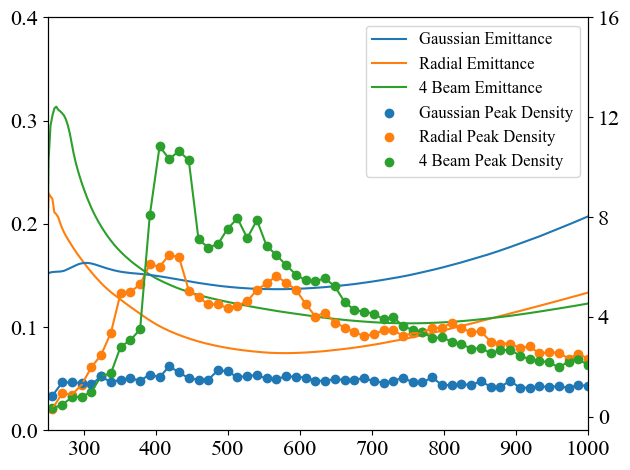

In [31]:
time_vals = np.linspace(0, 1000, emittance_vals_y_4petal.shape[0])
time_vals_density = np.linspace(0, 1000, peak_radial.shape[0])
FONT_SIZE = 16

fig, ax1 = plt.subplots()
radial_e_line = ax1.plot(time_vals, emittance_vals_y_radial, color='tab:orange', label='Radial Emittance')
petal4_e_line = ax1.plot(time_vals, emittance_vals_y_4petal, color='tab:green', label='4 Beam Emittance')
g_e_line = ax1.plot(time_vals, emittance_vals_y_g, color='tab:blue', label='Gaussian Emittance')
ax1.set_xlim(250, 1000)

xticks = np.array([300, 400, 500, 600, 700, 800, 900, 1000])
yticks = np.array([0, .1, .2, .3, .4])
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=FONT_SIZE)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=FONT_SIZE)

ax2 = ax1.twinx()  
ax2.plot(time_vals_density, peak_radial, color='tab:orange')
radial_density_line = ax2.scatter(time_vals_density, peak_radial, color='tab:orange', label='Radial Peak Density')
ax2.plot(time_vals_density, peak_4petal, color='tab:green')
petal4_density_line = ax2.scatter(time_vals_density, peak_4petal, color='tab:green', label='4 Beam Peak Density')
ax2.plot(time_vals_density, peak_g, color='tab:blue')
g_density_line = ax2.scatter(time_vals_density, peak_g, color='tab:blue', label='Gaussian Peak Density')
ax2.set_xlim(250, 1000)

xticks = np.array([300, 400, 500, 600, 700, 800, 900, 1000])
yticks = np.array([0, 4, 8, 12, 16])
ax2.set_xticks(xticks)
ax2.set_yticks(yticks)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=FONT_SIZE)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=FONT_SIZE)

fig.tight_layout()


lines = [g_e_line[0], radial_e_line[0], petal4_e_line[0], g_density_line, radial_density_line, petal4_density_line]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='upper right', fontsize=12)


In [32]:
y_vals = z_vals = np.linspace(-14.08, 14.08, 400) * 1e-6

def get_charge_through_screen(S, screen_num, cylinder_radius, y_vals, z_vals, l_x):
    dy = y_vals[1] - y_vals[0]
    dz = z_vals[1] - z_vals[0]
    Y, Z = np.meshgrid(y_vals, z_vals)
    mask = np.sqrt(Y**2 + Z**2) < cylinder_radius
    
    screen = S.Screen(screen_num, units=['fs', 'um', '1/cm^3'], timesteps = 99999, cmap=cmap)
    screen_data = np.array(screen.getData()[0])
    screen_w_mask = screen_data[mask]
    
    screen_m3 = screen_w_mask * (100**3)
    counts = screen_m3 * dz * dy * l_x
    total_count = counts.sum()
    total_charge = scipy.constants.e * total_count
    
    return total_count, total_charge

def get_charge_per_radius(S, screen_num, radius_vals, y_vals, z_vals, l_x):
    charge_vals = np.zeros(radius_vals.size)
    for i in range(charge_vals.size):
        _, charge = get_charge_through_screen(S, screen_num, radius_vals[i], y_vals, z_vals, l_x)
        charge_vals[i] = charge
    return charge_vals

In [33]:
radius_vals = np.linspace(.5, 10, 70) * 1e-6
CYLINDER_RADIUS = 5e-6
L_X = 48e-6
radial_charge_per_radius = get_charge_per_radius(S_radial, 0, radius_vals, y_vals, z_vals, L_X)
petal4_charge_per_radius = get_charge_per_radius(S_4petal, 0, radius_vals, y_vals, z_vals, L_X)
g_charge_per_radius = get_charge_per_radius(S_g_ap_match, 0, radius_vals, y_vals, z_vals, L_X)

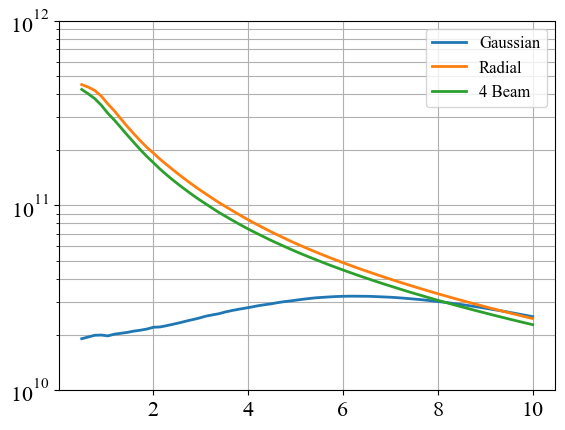

In [34]:
plt.figure()
plt.plot(radius_vals * 1e6, (((g_charge_per_radius) / 1e-12)) / ((radius_vals * 1e2)**2 * np.pi), 
         label='Gaussian', linewidth=2)
plt.plot(radius_vals * 1e6, (((radial_charge_per_radius) / 1e-12)) / ((radius_vals * 1e2)**2 * np.pi), 
         label='Radial', linewidth=2)
plt.plot(radius_vals * 1e6, (((petal4_charge_per_radius) / 1e-12)) / ((radius_vals * 1e2)**2 * np.pi), 
         label='4 Beam', linewidth=2)

plt.legend()

plt.yscale('log')
plt.ylim(1e10, 1e12)

FONT_SIZE = 16

plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which="both")

In [35]:
radial_screen_40um = np.array(S_radial.Screen(0, units=['fs', 'um'], timesteps = 999999).getData()[0])
petal4_screen_40um = np.array(S_4petal.Screen(0, units=['fs', 'um'], timesteps = 999999).getData()[0])
g_screen_40um = np.array(S_g_ap_match.Screen(0, units=['fs', 'um'], timesteps = 999999).getData()[0])

(-14.08, 14.08)

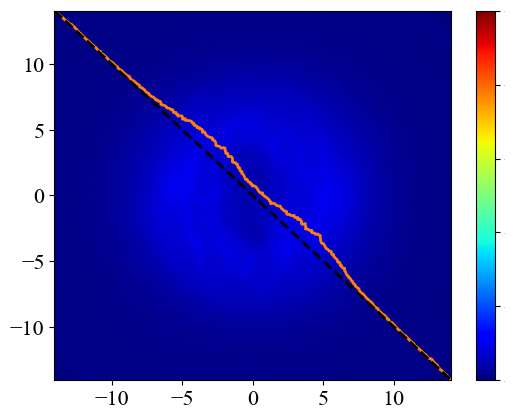

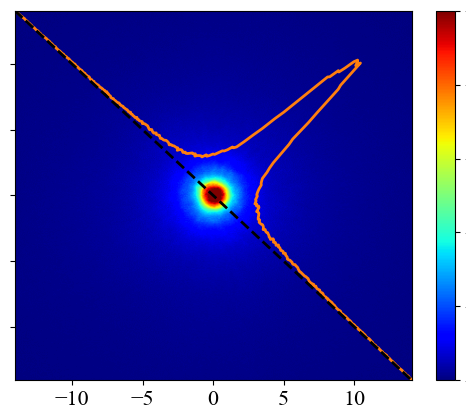

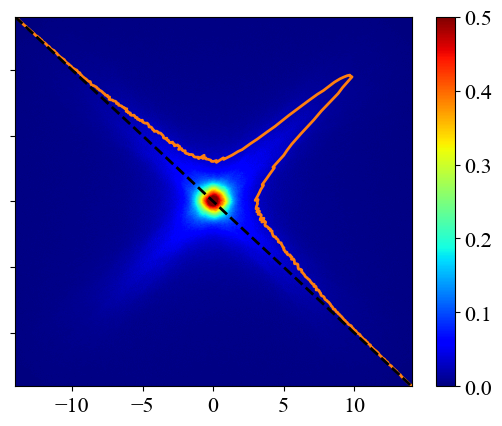

In [36]:
rotation_angle = np.deg2rad(45)
rotation_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])
SCALE = 25

FONT_SIZE = 16
plt.figure()
plt.imshow(g_screen_40um, aspect='auto', origin='lower', 
           extent=[-14.08, 14.08, -14.08, 14.08], cmap='jet', vmax=.5)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=0)

x_axis = np.linspace(-14.08, 14.08, g_screen_40um.shape[0])
x_axis2 = np.linspace(-14.08 * np.sqrt(2), 14.08 * np.sqrt(2), g_screen_40um.shape[0])
rotated_diag_x =  np.diag(g_screen_40um * SCALE) * rotation_matrix[0, 0] + x_axis2 * rotation_matrix[0, 1]
rotated_diag_y =  np.diag(g_screen_40um * SCALE) * rotation_matrix[1, 0] + x_axis2 * rotation_matrix[1, 1]
plt.plot(rotated_diag_x, rotated_diag_y, color='tab:orange', linewidth=2)

diag_vals = np.linspace(14.08, -14.08, petal4_screen_40um.shape[1])
plt.plot(x_axis, diag_vals, '--', color='black', linewidth=2)
plt.xlim(-14.08, 14.08)
plt.ylim(-14.08, 14.08)

plt.figure()
plt.imshow(radial_screen_40um, aspect='auto', origin='lower', 
           extent=[-14.08, 14.08, -14.08, 14.08], cmap='jet', vmax=.5)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=0)
plt.tick_params(axis='both', labelleft=False)

rotated_diag_x =  np.diag(radial_screen_40um * SCALE) * rotation_matrix[0, 0] + x_axis2 * rotation_matrix[0, 1]
rotated_diag_y =  np.diag(radial_screen_40um * SCALE) * rotation_matrix[1, 0] + x_axis2 * rotation_matrix[1, 1]
plt.plot(rotated_diag_x, rotated_diag_y, color='tab:orange', linewidth=2)

diag_vals = np.linspace(14.08, -14.08, petal4_screen_40um.shape[1])
plt.plot(x_axis, diag_vals, '--', color='black', linewidth=2)
plt.xlim(-14.08, 14.08)
plt.ylim(-14.08, 14.08)


plt.figure()
plt.imshow(petal4_screen_40um, aspect='auto', origin='lower', 
           extent=[-14.08, 14.08, -14.08, 14.08], cmap='jet', vmax=.5)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=FONT_SIZE)
plt.tick_params(axis='both', labelleft=False)

rotation_angle = np.deg2rad(45)
rotation_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])
rotated_diag_x =  np.diag(petal4_screen_40um * SCALE) * rotation_matrix[0, 0] + x_axis2 * rotation_matrix[0, 1]
rotated_diag_y =  np.diag(petal4_screen_40um * SCALE) * rotation_matrix[1, 0] + x_axis2 * rotation_matrix[1, 1]
plt.plot(rotated_diag_x, rotated_diag_y, color='tab:orange', linewidth=2)

diag_vals = np.linspace(14.08, -14.08, petal4_screen_40um.shape[1])
plt.plot(x_axis, diag_vals, '--', color='black', linewidth=2)
plt.xlim(-14.08, 14.08)
plt.ylim(-14.08, 14.08)

# Spectrum in the Supplemental

In [37]:
def getMaxIonEnergy(sim):
    timesteps = np.array(sim.ParticleBinning(0, units = ["um", "fs", "MeV"]).getTimesteps())
    diag=sim.ParticleBinning(0, units = ["um", "fs", "MeV"])
    
    maximum=0
    peak_timestep = 0
    for i, t in enumerate(timesteps):
        
        arr = np.array(diag.getData(timestep = t))[0]
        axis = diag.getAxis('ekin', timestep = t)
        idxvals=np.argwhere(arr>0)
        if len(idxvals) != 0:
            idx = idxvals[-1]
        else:
            idx=0
        l=np.linspace(axis[0],axis[-1], np.size(arr))
        if l[idx]>maximum:
            peak_timestep = t
            maximum = l[idx]

    return maximum[0], peak_timestep

In [38]:
max_base_case, timestep_base_case = getMaxIonEnergy(S_4petal)
max_radial, timestep_radial = getMaxIonEnergy(S_radial)
max_g_ap_match, timestep_g_ap_match = getMaxIonEnergy(S_g_ap_match)

In [39]:
base_case_spectrum = S_4petal.ParticleBinning(0, units=['um', 'fs', 'MeV'], timesteps = timestep_base_case)
radial_spectrum = S_radial.ParticleBinning(0, units=['um', 'fs', 'MeV'], timesteps = timestep_radial)
g_ap_match_spectrum = S_g_ap_match.ParticleBinning(0, units=['um', 'fs', 'MeV'], timesteps = timestep_g_ap_match)

base_case_spectrum_data = np.array(base_case_spectrum.getData()[0])
radial_spectrum_data = np.array(radial_spectrum.getData()[0])
g_ap_match_spectrum_data = np.array(g_ap_match_spectrum.getData()[0])

In [40]:
energies_base_case = base_case_spectrum.getAxis(axis='ekin', timestep=timestep_base_case)
energies_radial = radial_spectrum.getAxis(axis='ekin', timestep=timestep_radial)
energies_g_ap_match = g_ap_match_spectrum.getAxis(axis='ekin', timestep=timestep_g_ap_match)

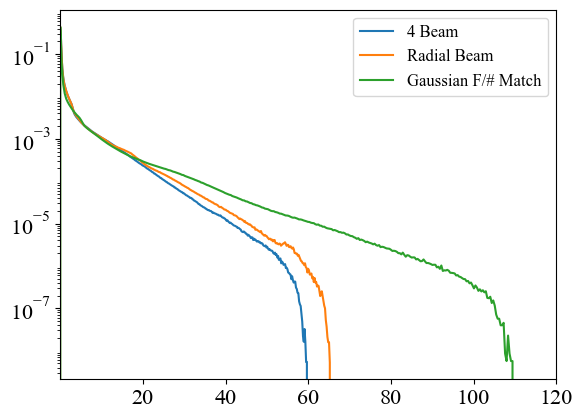

In [41]:
plt.figure()
FONT_SIZE = 16
plt.plot(energies_base_case, base_case_spectrum_data, label='4 Beam')
plt.plot(energies_radial, radial_spectrum_data, label='Radial Beam')
plt.plot(energies_g_ap_match, g_ap_match_spectrum_data, label='Gaussian F/# Match')
plt.yscale('log')
xticks = np.array([20, 40, 60, 80, 100, 120])
yticks = np.array([1e-1, 1e-3, 1e-5, 1e-7])
plt.xticks(xticks, fontsize=FONT_SIZE)
plt.yticks(yticks, fontsize=FONT_SIZE)
plt.xlim(0, 120)
plt.legend(fontsize=12)